In [1]:
import seaborn as sb
from scipy import stats
import math
import statistics as stat
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

отвергаем


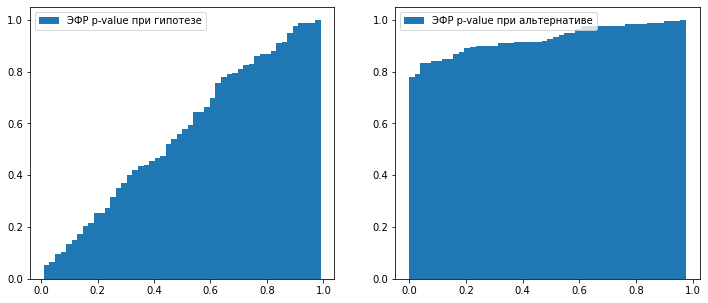

In [27]:
#@title №1(Крамер-фон Мизес)
#Реализовать сложные критерии Колмогорова, Крамера-фон Мизеса, Андерсона-Дарлинга для проверки принадлежности нормальному,
#используя метод Монте-Карло для вычисления предельного распределения p-value.
#Построить ЭФР p-value при гипотезе и при альтернативе, моделируя данные из распределения Стьюдента t5

from scipy import stats
import math
import statistics as stat
from scipy.stats import norm,t,uniform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

n=100
N=200
alpha=0.05

def cramer(samples,theta1,theta2):
    s=0
    samples=np.sort(samples)
    for i in range(n):
        s+=(2*(i+1)-1)/(2*n)-norm.cdf(samples[i],loc=theta1,scale=theta2)
    T=s**2+1/(12*n)
    return T

samples_0=norm.rvs(loc=3,scale=5,size=n)
theta1=np.mean(samples_0)
theta2=np.sqrt(np.var(samples_0))

samples=t.rvs(df=5,size=n)# выборка из распределения Стьюдента
T_0=cramer(samples,theta1,theta2)

#монте-карло
T=np.zeros(N)
k=0
for i in range(N):
    m_k=norm.rvs(loc=3,scale=5,size=n)
    theta1=np.mean(m_k)
    theta2=np.sqrt(np.var(m_k))
    T[i]=cramer(m_k,theta1,theta2)
    if(T_0<T[i]):
        k+=1
p_val=k/N
if p_val >= alpha:
    print('принимаем')
else:
    print('отвергаем')

#построение эфр p_value
p_value0 = np.zeros(N)
p_value1 = np.zeros(N)
for i in range(N):
    k_0=0
    k_1=0
    m_k=norm.rvs(loc=0,scale=7,size=n)
    theta1=np.mean(m_k)
    theta2=np.sqrt(np.var(m_k))
    T_00=cramer(m_k,theta1,theta2)
    s=t.rvs(df=5,size=n)
    T_01=cramer(s,theta1,theta2)
    for j in range(N):
        if (T[j]>T_00):
            k_0+=1
        if(T[j]>T_01):
            k_1+=1
    p_value0[i]=k_0/N
    p_value1[i]=k_1/N
    

    
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].hist(p_value0,bins=50,density=True,cumulative=True,label='ЭФР p-value при гипотезе')
axes[0].legend()
axes[1].hist(p_value1,bins=50,density=True,cumulative=True,label='ЭФР p-value при альтернативе')
axes[1].legend()
plt.show()

In [331]:
def likelihood_norm(params,sample):
    mu = params[0]
    sigma = params[1]
    if sigma <= 0:
        return np.inf
    L=-np.sum(stats.norm.logpdf(sample,loc=mu,scale=sigma))
    return L


def likelihood_disc(params, freq):
    mu = params[0]
    sigma = params[1]
    if sigma <= 0:
        return np.inf
    L = 0
    k = round((len(freq) - 1) / 2)
    a = np.zeros(k + 1)
    for i in range(k):
        a[i] = freq[k + i]
    a[-1] = np.inf
    for i in range(k):
        L += freq[i] * np.log(stats.norm.cdf((a[i + 1] - mu) / sigma) - stats.norm.cdf((a[i] - mu) / sigma))
    return -L

def chisq(n,k,nu,p):
    T = 0
    for i in range(k):
        T += (nu[i] - n * p[i])**2 / (n*p[i])
    return T

In [332]:
#2 i
import warnings
warnings.filterwarnings('ignore')

n=10000
mu = 5
sigma = 2
sample = np.sort(stats.norm.rvs(loc=mu,scale=sigma,size=n))
k = round(np.log(n)/np.log(2))
initial_guess = [0, 1]

freq = np.zeros(k) # равные частоты
for i in range(k-1):
    freq[i] = n // k
freq[k-1]=n // k + n%k

a_1 = np.zeros(k+1) # делим выборку на равные части
a_1[0] = -10000
a_1[k] = 10000
j = 0
for i in range(k-1):
    while j < np.cumsum(freq)[i]:
        a_1[i+1] = sample[j]
        j += 1

        
initial_guess = [0, 1] # делим выборку по квантилям омп (недискретного)
omp_norm = scipy.optimize.minimize(likelihood_norm, initial_guess, args=(sample,))
t = 0
a_2 = np.zeros(k+1)
a_2[0] = -10000
a_2[k] = 10000
for i in range(1,k):
    t += 1./k
    a_2[i] = stats.norm.ppf(t,loc=omp_norm.x[0],scale=omp_norm.x[1])


freq_1_omp = np.array(list(freq)+list(a_1))
freq_2_omp = np.array(list(freq)+list(a_2))
omp_1 = scipy.optimize.minimize(likelihood_disc, initial_guess, args=(freq_1_omp,)) # дискретные омп
omp_2 = scipy.optimize.minimize(likelihood_disc, initial_guess, args=(freq_2_omp,))
p_1 = np.zeros(k)
p_2 = np.zeros(k)
for i in range(k):
    if i == 0:
        p_1[i] = stats.norm.cdf(a_1[i+1],loc=omp_1.x[0],scale=omp_1.x[1])
        p_2[i] = stats.norm.cdf(a_2[i+1],loc=omp_2.x[0],scale=omp_2.x[1])
    else:
        p_1[i] = stats.norm.cdf(a_1[i+1],loc=omp_1.x[0],scale=omp_1.x[1]) - np.cumsum(p_1)[i-1] 
        p_2[i] = stats.norm.cdf(a_2[i+1],loc=omp_2.x[0],scale=omp_2.x[1]) - np.cumsum(p_2)[i-1]
        
nu_1 = freq
nu_2 = np.zeros(k)
j = 1
for i in range(k):
    if i == k - 1:
        nu_2[i] = n - np.sum(nu_2)
    else:
        while sample[j] < a_2[i+1]:
            nu_2[i] += 1
            j += 1
nu_1 = np.array([round(x) for x in nu_1])
nu_2 = np.array([round(x) for x in nu_2])
    
    
p_1 = np.array([round(n * p_1[i]) for i in range(len(p_1))])
p_2 = np.array([round(n * p_2[i]) for i in range(len(p_2))])
if np.sum(p_1) != n:
    p_1[0] += n-np.sum(p_1)
if np.sum(p_2) != n:
    p_2[0] += n-np.sum(p_2)
    
alpha = 0.05
quantile = stats.chi2.ppf(1-alpha,k-2)
print('квантиль y =',round(quantile,2))
print('\n#1 равные ячейки')
T_1 = stats.chisquare(f_obs=nu_1,f_exp=p_1,ddof=1).statistic
print('статистика T =',round(T_1,2))
if T_1 > quantile:
    print('отвергаем')
else: 
    print('принимаем')
print('\n #2 ячейки по квантилям')
T_2 = stats.chisquare(f_obs=nu_2,f_exp=p_2,ddof=1).statistic
print('статистика T =',T_2)
if T_2 > quantile:
    print('отвергаем')
else: 
    print('принимаем')

квантиль y = 19.68

#1 равные ячейки
статистика T = 8.55
принимаем

 #2 ячейки по квантилям
статистика T = 9.904461349379977
принимаем


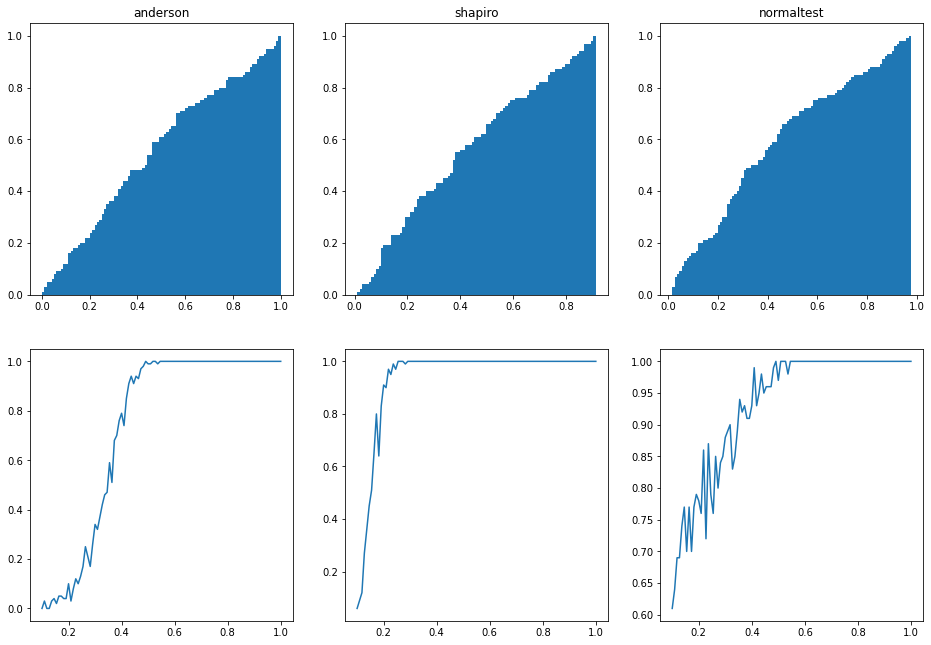

In [333]:
# @title №3(Вейбулл)
#3. Исследовать сгенерированные модельные данные X на нормальность, где Xi имеют распределение Вейбулла с параметром формы λ;
from scipy import stats
import math
import statistics as stat
from scipy.stats import norm,weibull_min,anderson,shapiro,normaltest
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

lambda_ = 3 #параметр формы
k = 1 #масштаб
N=100
n = N
alpha=np.linspace(0.1,1,n)
p_a=np.zeros(N)
p_s=np.zeros(N)
p_n=np.zeros(N)
w_a=np.zeros(N)
w_s=np.zeros(N)
w_n=np.zeros(N)
for i in range(N):
    samples=weibull_min.rvs(lambda_,scale=k,size=n)
    T_0_and=anderson(samples, dist='norm').statistic
    c_h0=0
    c_h1_and=np.zeros(n)
    c_h1_sha=np.zeros(n)
    c_h1_norm=np.zeros(n)
    for _ in range(N):
        #считаем p-value для Андерсона
        sample = norm.rvs(loc=0, scale=1, size=n)
        sample_wei = weibull_min.rvs(lambda_,scale=k,size=n)
        T = anderson(sample, dist='norm').statistic
        T_and = anderson(sample_wei,dist='norm').statistic
        T_sha = shapiro(sample_wei).statistic
        T_norm = normaltest(sample_wei).statistic
        if T > T_0_and: 
            c_h0+=1
        
        #ищем мощности критериев
        sample = np.sort(sample)
        sample_wei = np.sort(sample_wei)
        quantile = np.zeros(n)
        
        for j in range(n):
            quantile[j] = sample[math.floor((n-1)*(1-alpha[j]))] #квантили ЭФР
            if T_and > quantile[j]:
                c_h1_and[j] += 1
            if T_sha > quantile[j]:
                c_h1_sha[j] += 1
            if T_norm > quantile[j]:
                c_h1_norm[j] += 1
    w_a[i]=c_h1_and[i]/N
    w_s[i]=c_h1_sha[i]/N
    w_n[i]=c_h1_norm[i]/N
    
    p_a[i]=c_h0/N
    p_s[i]=shapiro(samples).pvalue
    p_n[i]=normaltest(samples).pvalue

fig, axes = plt.subplots(2, 3, figsize=(16, 11))
axes[0,0].hist(p_a,bins=N,density=True,cumulative=True)
axes[0,1].hist(p_s,bins=N,density=True,cumulative=True)
axes[0,2].hist(p_n,bins=N,density=True,cumulative=True)
axes[0,0].set_title('anderson')
axes[0,1].set_title('shapiro')
axes[0,2].set_title('normaltest')
axes[1,0].plot(alpha,w_a)
axes[1,1].plot(alpha,w_s)
axes[1,2].plot(alpha,w_n)
plt.show()

In [ ]:
# @title №3(Вейбулл)
#3. Исследовать сгенерированные модельные данные X на нормальность, где Xi имеют распределение Вейбулла с параметром формы λ;
from scipy import stats
import math
import statistics as stat
from scipy.stats import norm,weibull_min,anderson,shapiro,normaltest
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

lambda_ = 3 #параметр формы
k = 1 #масштаб
n=500
N=200
p_a=np.zeros(N)
p_s=np.zeros(N)
p_n=np.zeros(N)
for i in range(N):
  samples=weibull_min.rvs(lambda_,scale=k,size=n)
  T_0=anderson(samples, dist='norm').statistic
  c=0
  for _ in range(N):
    sample = norm.rvs(loc=0, scale=1, size=100)
    T = anderson(sample, dist='norm').statistic
    if T > T_0:
        c+=1
  p_a[i] =c/N
  p_s[i]=shapiro(samples).pvalue
  p_n[i]=normaltest(samples).pvalue

fig, axes = plt.subplots(1, 3, figsize=(12, 5))
axes[0].hist(p_a,bins=100,density=True,cumulative=True)
axes[1].hist(p_s,bins=100,density=True,cumulative=True)
axes[2].hist(p_n,bins=100,density=True,cumulative=True)
axes[0].set_title('anderson')
axes[1].set_title('shapiro')
axes[2].set_title('normaltest')
plt.show()